In [1]:
%cd ..

/home/maximilian/docker_home/geant4ScintSim/analysis


In [2]:
import json

import pythonSimHelper as psh

In [3]:
file = open("../sim/build/out.json")

In [4]:
# returns JSON object as 
# a dictionary
data = json.load(file)

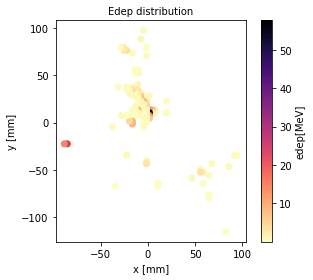

In [5]:
psh.plotEdepDistr(300, data)

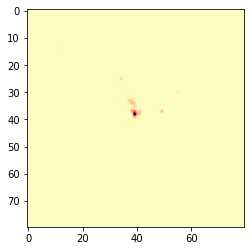

767.084539818853


In [6]:
import matplotlib.pyplot as plt
import numpy as np


#def plotCroppedImage(eventID: int, data: dict):

eventID = 0
f_size = 10

#x_data = []
#y_data = []
edep_data = np.zeros((80,80), dtype=float)

for key in data["event"][str(eventID)]["tileHitEdep"]:
    #x_data.append(data["geometry"]["tiles"][key]["posX"])
    #y_data.append(data["geometry"]["tiles"][key]["posY"])
    x = (int(key)+1)%80
    y = (int(key)+1) // 80
    edep_data[x][y] = data["event"][str(eventID)]["tileHitEdep"][key]

plt.imshow(edep_data, cmap="magma_r")
plt.show()


print(data["event"][str(eventID)]["particle_energy"])
    

In [7]:
from numpy import unravel_index
index = unravel_index(edep_data.argmax(), edep_data.shape)

In [8]:
edep_data_test = edep_data[index[0]-20:index[0]+20,index[1]-20:index[1]+20].flatten()


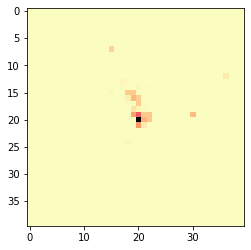

(1600,)

In [9]:
plt.imshow(edep_data_test.reshape((40,40)), cmap="magma_r")
plt.show()
edep_data_test.shape

In [30]:
x_data = []
y_data = []

edep_data = np.zeros((80,80), dtype=float)

for eventid in data["event"]:
    # print(eventid)
    if "tileHitEdep" not in data["event"][str(eventid)].keys():
        #print(eventid)
        continue
    for key in data["event"][str(eventid)]["tileHitEdep"]:
        #x_data.append(data["geometry"]["tiles"][key]["posX"])
        #y_data.append(data["geometry"]["tiles"][key]["posY"])
        x = (int(key))%80
        y = (int(key)) // 80
        edep_data[x][y] = np.log(data["event"][str(eventid)]["tileHitEdep"][key])
        
        index = unravel_index(edep_data.argmax(), edep_data.shape)
        edep_data_test = edep_data[index[0]-20:index[0]+20,index[1]-20:index[1]+20]
    
    if edep_data_test.shape != (40,40):
        continue
    x_data.append(np.array(edep_data_test))
    y_data.append(data["event"][str(eventid)]["particle_energy"]/5000)

In [31]:
len(x_data)

27567

In [12]:
data["event"]["1"]["tileHitEdep"]

{'1343': 0.2666073402320351,
 '2991': 0.21571199538109595,
 '3071': 0.1483384565416035,
 '3074': 1.10439061146808,
 '3075': 0.3003784000825534,
 '3077': 4.834084467254381,
 '3078': 1.7524928698611542,
 '3151': 0.6153664651040434,
 '3154': 6.232304410957039,
 '3155': 17.512602735599973,
 '3156': 22.68716887288822,
 '3157': 12.964036869129446,
 '3160': 0.022304302608564197,
 '3234': 0.47125772837617386,
 '3235': 25.454388269032037,
 '3236': 60.09873984739614,
 '3237': 56.373531966807505,
 '3238': 4.254981821953694,
 '3314': 0.3336797965621666,
 '3315': 0.5630408282471239,
 '3316': 14.024432212605937,
 '3317': 1.3254606686734816,
 '3395': 0.28998114968268407,
 '3396': 11.156580690844397,
 '3397': 8.516906139005256,
 '3477': 3.825468387684562,
 '3478': 0.39830543333945595,
 '3632': 1.7343344607049365,
 '3639': 0.16785019234676654,
 '3721': 0.5814223132464141,
 '3792': 0.06374668279399698,
 '3804': 0.08668823637457035,
 '3872': 1.809793216814822,
 '3952': 5.968048628721834,
 '3955': 0.16833

In [32]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn

In [33]:
from matplotlib import pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings("ignore")

In [34]:
np.array(x_data).shape

(27567, 40, 40)

In [35]:
x_train = torch.Tensor(np.array(x_data).reshape(-1, 1, 40,40).astype('float32'))

y_train = torch.Tensor(y_data).unsqueeze(-1)

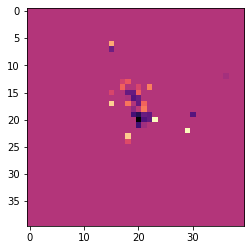

In [36]:
# Test if everything is still ok
plt.imshow(np.array(x_train[0][0]), cmap="magma_r")
plt.show()

In [37]:
class cnn_data( Dataset ):
    
    def __init__( self, imgs, labels ):
        self.imgs = imgs
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.imgs[idx], self.labels[idx]

In [38]:
train_cnn_dataset = cnn_data(x_train, y_train.float())

In [39]:
train_cnn_dataloader = DataLoader( train_cnn_dataset, batch_size=32, shuffle=True )

In [40]:
class ConvNet2D(nn.Module):
    
    def __init__(self, in_ch=1, ch=4, out_dim=1, img_sz=40):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, ch, kernel_size=4, bias=True, stride=1, padding=2)
        self.conv2 = nn.Conv2d(ch, 1, kernel_size=4, bias=True, stride=1, padding=2)
        self.max = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(int(img_sz*img_sz/16), 80, bias=True)
        self.dense2 = nn.Linear(80, 50, bias=True)
        self.dense3 = nn.Linear(50, out_dim, bias=True)
        
    def forward(self, x):
        self.net = nn.Sequential(
            self.conv1,
            nn.ReLU(),
            self.max,
            nn.ReLU(),
            self.conv2,
            self.max,
            self.flatten,
            self.dense1,
            nn.ReLU(),
            self.dense2,
            nn.ReLU(),
            self.dense3,
            #nn.Sigmoid()
        )
        return self.net(x)
    

In [41]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [42]:
loss_fn = nn.L1Loss()

In [43]:
def train_epoch( dataloader, model, loss_fn, optimizer ):
    
    size = len( dataloader.dataset )
    
    for batch, (X, y) in enumerate(dataloader):

        # pass data through network
        pred = model(X)
        
        # compute loss
        loss = loss_fn( pred, y )

        # reset gradients in optimizer
        optimizer.zero_grad()
        
        # compute gradients
        loss.backward()
        
        # update weights with optimizer
        optimizer.step()
        
        # print the training loss every 100 updates
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print( f"current batch loss: {loss:>7f}  [{current:>5d}/{size:>5d}]" )

In [44]:
# a useful function to present things clearer
def separator():
    print( "-----------------------------------------------" )

epochs = 30

# re-initialise the model and the optimizer
model = ConvNet2D(ch=8).to(device)
learning_rate = 0.001
optimizer = torch.optim.Adam( model.parameters(), lr=learning_rate )
separator()
print( "model architecture ")
separator()
print( model )

# track train and val losses
trn_losses = []
val_losses = []

for t in range(epochs):
    separator()
    print( f"Epoch {t+1}" )
    separator()
    train_epoch( train_cnn_dataloader, model, loss_fn, optimizer )
    separator()
    #trn_loss = trn_pass( train_cnn_dataloader, model, loss_fn )
    #trn_losses.append( trn_loss )
    #separator()
    #val_loss = val_pass( val_cnn_dataloader, model, loss_fn )
    #val_losses.append( val_loss )
    separator()
    print( "|" )
    
print("Done!")

-----------------------------------------------
model architecture 
-----------------------------------------------
ConvNet2D(
  (conv1): Conv2d(1, 8, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(8, 1, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
  (max): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense1): Linear(in_features=100, out_features=80, bias=True)
  (dense2): Linear(in_features=80, out_features=50, bias=True)
  (dense3): Linear(in_features=50, out_features=1, bias=True)
)
-----------------------------------------------
Epoch 1
-----------------------------------------------
current batch loss: 0.615008  [    0/27567]
current batch loss: 0.231902  [ 3200/27567]
current batch loss: 0.205560  [ 6400/27567]
current batch loss: 0.241852  [ 9600/27567]
current batch loss: 0.230092  [12800/27567]
current batch loss: 0.246224  [16000/27567]
current batch loss: 0.144514  [192

current batch loss: 0.207995  [25600/27567]
-----------------------------------------------
-----------------------------------------------
|
-----------------------------------------------
Epoch 14
-----------------------------------------------
current batch loss: 0.189156  [    0/27567]
current batch loss: 0.172432  [ 3200/27567]
current batch loss: 0.190753  [ 6400/27567]
current batch loss: 0.261826  [ 9600/27567]
current batch loss: 0.192479  [12800/27567]
current batch loss: 0.169104  [16000/27567]
current batch loss: 0.201374  [19200/27567]
current batch loss: 0.208392  [22400/27567]
current batch loss: 0.167211  [25600/27567]
-----------------------------------------------
-----------------------------------------------
|
-----------------------------------------------
Epoch 15
-----------------------------------------------
current batch loss: 0.190664  [    0/27567]
current batch loss: 0.198340  [ 3200/27567]
current batch loss: 0.186272  [ 6400/27567]
current batch loss: 0.

current batch loss: 0.202698  [12800/27567]
current batch loss: 0.161274  [16000/27567]
current batch loss: 0.132038  [19200/27567]
current batch loss: 0.188848  [22400/27567]
current batch loss: 0.152080  [25600/27567]
-----------------------------------------------
-----------------------------------------------
|
-----------------------------------------------
Epoch 28
-----------------------------------------------
current batch loss: 0.188702  [    0/27567]
current batch loss: 0.164897  [ 3200/27567]
current batch loss: 0.229267  [ 6400/27567]
current batch loss: 0.230194  [ 9600/27567]
current batch loss: 0.167854  [12800/27567]
current batch loss: 0.126746  [16000/27567]
current batch loss: 0.199742  [19200/27567]
current batch loss: 0.135909  [22400/27567]
current batch loss: 0.213387  [25600/27567]
-----------------------------------------------
-----------------------------------------------
|
-----------------------------------------------
Epoch 29
--------------------------

In [52]:
pred = model(train_cnn_dataset[99][0])

In [53]:
pred

tensor([[0.1946]], grad_fn=<AddmmBackward0>)

In [54]:
train_cnn_dataset[99][1]

tensor([0.2118])

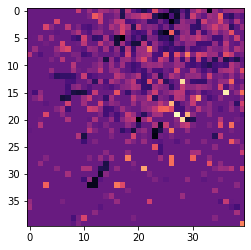

In [51]:
plt.imshow(np.array(train_cnn_dataset[99][0][0]), cmap="magma_r")
plt.show()

In [71]:
abw = []
with torch.no_grad():
    for index in range(20000):
        pred = model(train_cnn_dataset[index][0])
        abw.append(float(pred[0])-float(train_cnn_dataset[index][1]))

In [72]:
abw_np = np.array(abw)

In [74]:
abw_np.mean()*5000

-76.98914088743913

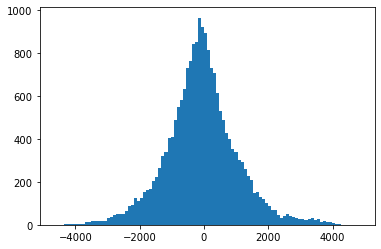

In [78]:
plt.hist(abw_np*5000, bins=100)
plt.show()